In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss

import logging
logger = logging.getLogger('qick.qick_asm')
logger.setLevel(logging.ERROR)
import yaml

from tqdm import tqdm_notebook as tqdm
from TomoAnalysis import TomoAnalysis
import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import InstrumentManager
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Warning serial library import failed.
Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
Could not load InstrumentManagerWindow
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amprabi_opt_ctrl_state_prep
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.crosstalk_echo_calib
imp

# Importing param

In [4]:
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
im = InstrumentManager(ns_address='10.108.30.56')

with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# State tomography analysis functions

Measurement occurs along 3^3=27 axes, each of which can give one of 2^3=8 values

## Basis definitions

In [48]:
meas_order = meas.three_qubit.threeQ_state_tomo.make_3q_meas_order()
calib_order = meas.three_qubit.threeQ_state_tomo.make_3q_calib_order()
Tomo =TomoAnalysis(nb_qubits=3, rfsoc_config=soc, meas_order=meas_order, calib_order=calib_order)

calib_order_numeric = Tomo.calib_order_numeric

# Run experiment and analysis

In [49]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [50]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [51]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

Default Instrument SC_26C1


0

## Run experiment and acquire data

### Test 3Q tomo

In [52]:
save_data = False
saved_files = []

In [53]:
tomo_qubits = [0, 2, 3] # which qubit/resonator we want to probe

In [54]:
tomoExpt = meas.TestStateTomo3QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_3q_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}{tomo_qubits[2]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=30000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
)

print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

if save_data: saved_files.append(tomoExpt.save_data())

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0489384211, 5794.889333329999, 501.37390000000005, -229.8457739], 'gain': [0.48, 0.8, 0.95, 0.5], 'readout_length': [8.0, 7.0, 6.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4109.191979657045, 3452.975577150007, 4763.932068792744, 4380.622407106254], 'f_ef': [3883.3488000631655, 3318.638485737792, 4576.568833764635, 4207.908734138744], 'f_Q1_ZZ': [3447.6492111444663, 0, 3451.6989648755653, 3451.487891370523], 'f_Q_ZZ1': [4104.0390507312995, 0, 4762.714105774562, 4379.368522661373], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5885.4, 5138.925], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.6415018214608046, 6.386231497692186], 'ZZs': [0.0, -5.179338580947842, -0.155448999276814, -0.4803728057531771, -5.178529648655058, 0.0, -1.1287759175561405, -1.3398494225984905, -0.129275729158

  0%|          | 0/8 [00:00<?, ?it/s]

Pyro traceback:
Traceback (most recent call last):
  File "<ipython-input-54-cd387cb2b3ed>", line 17, in <module>
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
  File "C:\_Lib\python\slab\experiment.py", line 115, in go
    data=self.acquire(progress)
  File "s:\Connie\experiments\qramLL_4QR2\experiments\three_qubit\threeQ_state_tomo.py", line 298, in acquire
    err_tomo.acquire(self.im[self.cfg.aliases.soc], load_pulses=True, progress=False)
  File "c:\Users\slab\anaconda3\lib\site-packages\qick\averager_program.py", line 106, in acquire
    d_buf, avg_d, shots = super().acquire(soc, soft_avgs=self.soft_avgs, reads_per_rep=readouts_per_experiment, load_pulses=load_pulses, start_src=start_src, progress=progress)
  File "c:\Users\slab\anaconda3\lib\site-packages\qick\qick_asm.py", line 978, in acquire
    self.config_all(soc, load_pulses=load_pulses)
  File "c:\Users\slab\anaconda3\lib\site-packages\qick\asm_v1.py", line 644, in config_all
    super().config_

In [56]:
from experiments.two_qubit.twoQ_state_tomography import correct_readout_err, fix_neg_counts

In [58]:
# tomo = tomoExpt

data, attrs = prev_data(expt_path, '00015_QramProtocol3QTomo.h5')
pulse_dict = attrs['pulse_dict']
assert np.all(np.array(attrs['meas_order']) == meas_order)
assert np.all(np.array(attrs['calib_order']) == calib_order)
# print(meas_order)
# print(calib_order)

# data = tomo.data
# pulse_dict = tomo.pulse_dict
# assert np.all(np.array(tomo.meas_order) == meas_order)
# assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

np.set_printoptions(suppress=True)

# print('Tomography counts')
# print(n_tomo_raw)
# print('Confusion matrix counts')
# print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(Tomo.correct_readout_err(n_tomo_raw, n_calib))
print('Negative counts corrected tomo matrix will be')
print(Tomo.fix_neg_counts(Tomo.correct_readout_err(n_tomo_raw, n_calib)))

n_tomo = Tomo.fix_neg_counts(Tomo.correct_readout_err(n_tomo_raw, n_calib))

s:\Connie\experiments\qramLL_4QR2\data\data_240617\00015_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
Confusion matrix corrected tomo matrix will be
[[49220.32379   259.63084  1030.54592   -39.66842 48784.73994   643.88637
     19.18041    81.36115]
 [25241.44792 24244.65928   722.6699    197.41234 24442.764   25019.24521
    364.84061  -233.03927]
 [24659.97958 23970.10658   714.7991    354.93754 24995.04    25254.25539
    273.33259  -222.45078]
 [23672.58327    64.98382 25554.36466   161.14052 23594.12172   516.82765
  25886.92584   549.05252]
 [12115.55809 11973.03905 13237.06965 12429.04655 12091.91631 12071.03871
  13455.92824 12626.40341]
 [12221.98199 11801.20822 12967.17968 12218.3112  11976.28511 12109.1666
  13751.48961 12954.37759]
 [23917.33064    81.0326  25926.31998    11.2607  23707.61407   388.73962
  25519.30344   448.39895]
 [11772.60171 12020.48846 13507.12936 12397.27692 12074.84647 12073.2893
  13328.56982 12

### Qram experiment

In [59]:
tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 1, 2] # which qubit/resonators to do tomo on

In [ ]:
save_data = True
saved_files = []

In [ ]:
init_state = '|0+1>|0>' # Q0/Q1 (switch, input)

play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

In [ ]:
qramExpt = meas.QramProtocol3QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

# span = 2.161196963262976 # total time [us]
# span = 1.1659462011134218 # total time [us]
span = np.inf
npts = 1
# span = 1.8 # total time [us]
# npts = 120
# span = 0.8 # total time [us]
# npts = 10
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=75000, # number of reps per tomo/time step,
    # singleshot_reps=1, # reps per state for singleshot calibration
    singleshot_reps=75000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    tomo_3q=True, # flag to perform tomo on last time step
    tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
    init_state=init_state,
    play_pulses=play_pulses, # [2, 1, 4, 3]
    
    # thresholds=[422.1953318059096, 0, 487.65681563474595, 497.6429184949339],
    # angles=[158.10236394502965, 0, -106.39920816100101, 82.86317173115363],
    # ge_avgs=[[-292.361227803092, 47.268840862489824, -616.6156633197722, -105.53606568755086], [0, 0, 0, 0], [-199.78032794357028, 189.52293695062394, -341.494269918611, 700.507366359197], [-130.8798941844485, -357.95815466184445, -98.2075591681736, -673.2342717830019]] ,
    # counts_calib=[[40352, 3435, 1576, 161, 3858, 433, 159, 26], [5341, 38709, 219, 1544, 436, 3551, 27, 173], [3318, 244, 38953, 3285, 285, 36, 3477, 402], [452, 3310, 5351, 36499, 43, 300, 469, 3576], [6231, 545, 225, 22, 37919, 3381, 1514, 163], [860, 6494, 42, 286, 5066, 35614, 214, 1424], [506, 41, 5956, 536, 3156, 268, 36331, 3206], [72, 516, 832, 6182, 432, 3064, 4914, 33988]]
)

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=False, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# tomo = qramExpt
# data = tomo.data
# n_tomo_raw = np.array(data['counts_tomo'])
# n_calib = np.array(data['counts_calib'])

# n_tomo_raw_rounds.append(n_tomo_raw)
# n_calib_rounds.append(n_calib)
# n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

if save_data: saved_files.append(qramExpt.save_data())

post processing counts

In [ ]:
tomo = qramExpt
data = tomo.data
n_tomo_raw = np.array(data[f'counts_tomo'])
n_calib = np.array(data['counts_calib'])
n_tomo_readout_corrected = correct_readout_err(n_tomo_raw, n_calib)
n_tomo_corrected = fix_neg_counts(n_tomo_readout_corrected)
pulse_dict = qramExpt.pulse_dict

n_tomo = n_tomo_corrected

print('Raw tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('n_tomo')
print(n_tomo)
print('Corrected tomo with calib counts')
print(n_tomo_readout_corrected)
print('Corrected tomo with calib counts, corrected for neg counts')
print(n_tomo_corrected.astype(int))


In [ ]:
filename = saved_files[-1]

### Import optimal control pulse

In [ ]:
pulse_filepath = os.path.join(os.getcwd(), '240528_pulse_sequence_pp.npz')
pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

### Big qram protocol loop!

In [ ]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
save_data = True
saved_files = []

print('init_states', init_states)
print('protocol_play', protocol_play)
print('save data', save_data)
if not save_data:
    print('WARNING!! YOU ARE NOT SAVING DATA!')

In [ ]:
play_pulses = protocol_play
for init_state in init_states:
    print('init_state', init_state, 'play pulses', play_pulses)
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=100000, # number of reps per tomo/time step,
        singleshot_reps=100000, # reps per state for singleshot calibration
        # reps=100, #000, # number of reps per tomo/time step,
        # singleshot_reps=100, #000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        
        use_IQ_pulse=True,
        plot_IQ=False,
    )
    
    success = False
    while not success:
        try:
            qramExpt.go(analyze=False, display=False, progress=False, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

In [ ]:
print('init_states =', init_states)
print(saved_files)

In [ ]:
saved_files = ['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00000_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00019_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00020_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00021_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240508\\00022_QramProtocol3QTomo.h5']

##### Loop analysis

In [ ]:
# RETRIEVE SAVED 2Q TOMO INITIAL STATES FROM MEASUREMENT
rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\202406261053_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ_dict retrieved with init_states {rho_MLE_ZZ_dict.keys()}')

In [ ]:
init_states = []
rhos_base = []
fidelities_base = []
purities_base = []

rhos_ZZ = []
fidelities_ZZ = []
purities_ZZ = []

fidelities_opt_rot = []
all_best_phis = []
saveplots = False
# save_append = '_compareMeas'
save_append = ''
fids_grids = []

phis = [None, None, None]
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    init_state = cfg.expt.init_state
    init_states.append(init_state)
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    n_tomo_raw = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])
    n_tomo_corrected = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))
    n_tomo = n_tomo_corrected
    
    
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    # ------------------------------ #
    # Base MLE
    # ------------------------------ #
    
    rho_MLE_base = run_MLE_analytical(n=n_tomo, ZZ_correction=False)
    
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (base): {fid_base}')
    # print(f'Purity (base): {purity_base}')
    # print(f'Target purity: {purity_id}')
    
    # if saveplots: savetitle = saved_file[:-3]+f'_base{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    rhos_base.append(rho_MLE_base)
    fidelities_base.append(fid_base)
    purities_base.append(purity_base)
    
    rho_MLE = rho_MLE_base

#     # ------------------------------ #
#     # MLE with ZZ
#     # ------------------------------ #

#     # rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats) #, method='Powell')
#     rho_MLE_ZZ = run_MLE_analytical(n=n_tomo, ZZ_correction=True, evol_mats=evol_mats)

#     fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
#     purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
#     purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
#     # print(f'Fidelity (with ZZ correction): {fid_ZZ}')
#     # print(f'Purity (with ZZ correction): {purity_ZZ}')
#     # print(f'Target purity: {purity_id}')

#     # if saveplots: savetitle = saved_file[:-3]+f'_ZZcorrect{save_append}.svg'
#     # else: savetitle = None
#     # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

#     rhos_ZZ.append(rho_MLE_ZZ)
#     fidelities_ZZ.append(fid_ZZ)
#     purities_ZZ.append(purity_ZZ)

#     rho_MLE = rho_MLE_ZZ

    # ------------------------------ #
    # MLE with opt rot
    # ------------------------------ #
    
    phis[0] = np.linspace(0, 360, 30) # Q0
    phis[1] = np.linspace(0, 360, 30) # Q2
    phis[2] = np.linspace(0, 360, 30) # Q3
    if init_state == '|0+1>|0+1>' or init_state == '|0+1>|1>': phis[0] = np.linspace(0, 360, 30)
        
    rho_MLE_rot, best_phis, best_fid, fids_grid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis, progress=False)
    fids_grids.append(fids_grid)
    
    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep

#     vmax = np.max(fids_grid)
#     for i_phi0, phi0 in enumerate(phis[0]):
#         print(f'phi Q0 {phi0}')
#         plt.figure()
#         plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})')
#         plt.xlabel(f'phis Q{tomo_qubits[2]}')
#         plt.ylabel(f'phis Q{tomo_qubits[1]}')
#         plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
#         plt.colorbar()
#         plt.clim(vmin=0, vmax=vmax)
#         plt.show()

    z_phi123 = z_gate_3q(*best_phis)
    rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    
    purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (after rotation): {fid_rot}')
    # print(f'Purity (after rotation): {purity_MLE_rot}')
    # print(f'Target purity: {purity_id}')
    # print(f'Best rotation: {best_phis}')
    
    # if saveplots: savetitle=saved_file[:-3]+f'_ZZcorrect_optrot{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    fidelities_opt_rot.append(best_fid)
    all_best_phis.append(best_phis)
    
    # print('\n\n\n')

In [ ]:
print('Input states', init_states)
print('Saved files', saved_files)
print('fidelities base MLE\n', fidelities_base)
print('ZZ correction fidelities\n', fidelities_ZZ)
# print('Optimal phi with base MLE fidelities\n', fidelities_opt_rot)
print('Optimal phi with ZZ correction fidelities\n', fidelities_opt_rot)
print('best_phis\n', all_best_phis)
print('purities (base MLE)\n', purities_base)
print('purities (ZZ correction)\n', purities_ZZ)

In [ ]:
# Pick best overall phi

phis[0] = np.linspace(0, 360, 30) # Q0
# phis[0] = [0] # Q00
phis[1] = np.linspace(0, 360, 30) # Q2
phis[2] = np.linspace(0, 360, 30) # Q3

# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0>', '|0+1>|0+1>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>']
# check_init_states = ['|0+1>|0+1>']
check_init_states = init_states
    

fids_grids_reshaped = []
for i_state in range(len(init_states)):
    grid_shape = fids_grids[i_state].shape
    print(grid_shape)
    fids_grid = np.copy(fids_grids[i_state]).tolist()
    # print(init_states[i_state], grid_shape)
    if grid_shape[0] == 1:
        for i in range(grid_shape[1]-1):
            fids_grid.append(fids_grid[0])
    # print(np.array(fids_grid).shape)
    fids_grids_reshaped.append(fids_grid)

fids_grids_reshaped = np.array(fids_grids_reshaped)
print(fids_grids_reshaped.shape)


best_avg_fid = 0
best_fids = []
best_phis = [0, 0, 0]
best_phi_indices = [0, 0, 0]
for iphi0, phi0 in enumerate(phis[0]):
    for iphi1, phi1 in enumerate(phis[1]):
        for iphi2, phi2 in enumerate(phis[2]):
            avg_fid = 0
            for i_state, init_state in enumerate(init_states):
                if init_state not in check_init_states: continue
                avg_fid += fids_grids_reshaped[i_state][iphi0, iphi1, iphi2]
            avg_fid /= len(check_init_states)
            if avg_fid > best_avg_fid:
                best_phis = [phi0, phi1, phi2]
                best_phi_indices = [iphi0, iphi1, iphi2]
                best_avg_fid = avg_fid

for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    best_fids.append(fids_grids_reshaped[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

print('best avg fid', best_avg_fid)
print('best fids for check states', best_fids)
print('best phis', best_phis)

z_phi123 = z_gate_3q(*best_phis)

print()
for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    print('init_state', init_state)
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    init_rho = rho_MLE_ZZ_dict[init_state]
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    # rho_MLE_rot = (z_phi123*qt.Qobj(rhos_ZZ[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    rho_MLE_rot = (z_phi123*qt.Qobj(rhos_base[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (after rotation): {fid_rot}')
    print(f'Purity (after rotation): {purity_MLE_rot}')
    print(f'Target purity: {purity_id}')
    
    if saveplots: savetitle=saved_file[:-3]+f'_ZZcorrect_optrot{save_append}.svg'
    else: savetitle = None
    show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ, Phase Corrected (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})\nInit {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    print()

## Run analysis

### Reopen old data

In [60]:
filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\00006_QramProtocol3QTomo.h5'
# data, attrs = prev_data(expt_path, '00009_QramProtocol3QTomo.h5')
saved_files.append(filename)
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
init_state = cfg.expt.init_state
play_pulses = cfg.expt.play_pulses
tomo_qubits = cfg.expt.tomo_qubits
print('init_state', init_state)
print('play_pulses', play_pulses)
print('tomo_qubits', tomo_qubits)

np.set_printoptions(suppress=True)
n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])
n_tomo_corrected = Tomo.fix_neg_counts(Tomo.correct_readout_err(n_tomo_raw, n_calib))
n_tomo = n_tomo_corrected
# print('n_tomo')
# print(n_tomo)
print('counts_calib')
print(data['counts_calib'])
print(attrs['calib_order'])

print(f'thresholds={data["thresholds"].tolist()},')
print(f'angles={data["angles"].tolist()},')
print(f'ge_avgs={data["ge_avgs"].tolist()}',',')
print(f'counts_calib={data["counts_calib"].tolist()}')

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
calib_order ['ggg', 'gge', 'geg', 'gee', 'egg', 'ege', 'eeg', 'eee']
meas_order ['ZZZ', 'ZZX', 'ZZY', 'ZXZ', 'ZXX', 'ZXY', 'ZYZ', 'ZYX', 'ZYY', 'XZZ', 'XZX', 'XZY', 'XXZ', 'XXX', 'XXY', 'XYZ', 'XYX', 'XYY', 'YZZ', 'YZX', 'YZY', 'YXZ', 'YXX', 'YXY', 'YYZ', 'YYX', 'YYY']
dict_keys(['angles', 'counts_calib', 'counts_raw', 'counts_tomo', 'epop', 'fpop', 'ge_avgs', 'gpop', 'thresholds', 'xpts'])
init_state |0+1>|0>
play_pulses [2, 1, 4, 3]
tomo_qubits [0, 2, 3]
counts_calib
[[80112  7603  3336   311  7426   800   319    93]
 [17261 70641   786  2842  1682  6352    81   355]
 [ 8218   698 75986  6861   708    71  6796   662]
 [ 2067  7341 20248 61935   205   680  1904  5620]
 [10849   945   482    41 77258  6809  3307   309]
 [ 2200  9312   103   361 17008 67211   820  2985]
 [ 1021    91  9504   829  7645   705 73901  6304]
 [  239   8

In [ ]:
# # counts_calib = data['counts_calib']
# counts_calib=[array([3189,  426, 3176,  519, 1176,  198, 1110,  206]), array([ 580, 3047,  582, 3015,  207, 1148,  221, 1200]), array([1963,  289, 4456,  583,  721,   97, 1661,  230]), array([ 390, 1850,  812, 4372,  130,  683,  269, 1494]), array([1336,  209, 1293,  232, 2954,  473, 2981,  522]), array([ 256, 1341,  226, 1320,  512, 2924,  557, 2864]), array([ 809,  118, 1892,  295, 1810,  262, 4215,  599]), array([ 167,  796,  352, 1830,  325, 1776,  781, 3973])]


# # introduce gaussian noise
# np.random.seed(0)
# noise = 2.0
# n = np.copy([counts_calib[4]])
# print(n, sum(n))
# n0 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n0)
# print('fix neg counts', fix_neg_counts(n0))

# if noise is not None:
#     for n_psi in n:
#         n_meas = sum(n_psi)
#         new_nlast = -1
#         while new_nlast < 0:
#                 new_n_uptolast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
#                 # new_n_uptolast *= 1 - np.isnan(new_n_uptolast) # 0 out the nans
#                 # print('here', new_n_uptolast)
#                 # preserve original total count per measurement
#                 new_nlast = n_meas - sum(new_n_uptolast)
#                 n_psi[:-1] = np.round(new_n_uptolast)
#                 n_psi[-1] = np.round(new_nlast)

# print(1)
# print(n, sum(n))
# print(type(n))
# print(np.shape(n))
# print(n[0].dtype)
# n = np.array(n, dtype=float)
# n1 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n1)
# print('fix neg counts', fix_neg_counts(n1))


# # print('n1-n2')
# # print(n1-n2)

# print(3)
# n = [[ 287, 1291,  675, 2954,  256, 1250,  554, 2733]]
# print(n)
# n = correct_readout_err(n, n_conf=counts_calib)
# print(sum(n))
# print(fix_neg_counts(n))

# print(4)
# correct_readout_err(counts_calib, counts_calib)

### Set ideal rho

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [62]:
# Define the basis of psis

psiZ = [qt.basis(2,0), qt.basis(2,1)]
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric):
    psis.update({label_numeric:Tomo.psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [63]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
def get_qram_qSLR_state_from_rho(init_rho_SI, post_select=False, post_select_state=None):
    """
    init_rho_SI should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.shape(init_rho_SI) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_SI[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

### Get final qram state from an arbitrary 2Q input density matrix

In [66]:
print('init state Q0 (switch) Q1 (input):', init_state)

# init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
# if init_state == '|0+1>|0+1>':
#     init_rho = np.array([[(0.23+0j), (0.057+0.233j), (0.18-0.099j), (-0.078+0.08j)], [(0.057-0.233j), (0.287+0j), (-0.016-0.171j), (-0.013+0.114j)], [(0.18+0.099j), (-0.016+0.171j), (0.266+0j), (-0.166+0.121j)], [(-0.078-0.08j), (-0.013-0.114j), (-0.166-0.121j), (0.217+0j)]])
# init_rho = qt.ket2dm((name_to_state_2q('|1>|0>') + name_to_state_2q('|1>|1>') + name_to_state_2q('|0>|0>') + 1j*name_to_state_2q('|0>|1>')).unit())

# rho_id = get_qram_qSLR_state_from_rho(init_rho)
# rho_id


# # rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'
rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402291250_init_rhoMLE_ZZ_2Q_01.npz'

# print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
# print(f'rho_MLE_ZZ retrieved with init_states {rho_MLE_ZZ_dict.keys()}')
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

init state Q0 (switch) Q1 (input): |0+1>|0>


KeyError: '|0+1>|0>'

In [80]:
# psi_id = qt.tensor(psiZ[1]+psiZ[0], psiZ[0], psiZ[1]+psiZ[0]).unit()
# psi_id = qt.tensor(psiZ[1], psiZ[0], psiZ[1]).unit()
# rho_id = qt.ket2dm(psi_id)
rho_id = qt.ket2dm(psis['100'] + psis['000']).unit()
# print(rho_id.dims)

### Generate test data

In [81]:
# rho_id = qt.ket2dm(psi10 + psi11).unit()

# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo_sim = Tomo.generate_counts(rho_id=rho_id, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = generate_counts(rho_id=rho_MLE_ZZ, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = n_tomo_sim
print(n_tomo_sim)

print(meas_order)
print(calib_order)
print('difference')
print(np.round((n_tomo_sim - n_tomo)/100000, 2))

NameError: name 'evol_mats' is not defined

In [ ]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
# n_calib = qt.qeye(4).full()
# print(fix_neg_counts(n_tomo))

### Run MLE without ZZ correction

In [130]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
# rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
rho_MLE_base = Tomo.run_MLE_analytical(n_tomo=n_tomo, ZZ_correction=False)

print(rho_MLE_base)

[[ 0.44536505-0.j          0.00442061-0.00349765j  0.09681902-0.09610465j
  -0.00315911-0.00354887j  0.44049753-0.00531096j  0.01121388-0.00481348j
   0.09678109-0.09326245j -0.00179875-0.00879642j]
 [ 0.00442061+0.00349765j  0.00130788-0.j          0.00130588-0.0005552j
   0.00001523-0.00015837j  0.00737626+0.00865019j -0.00092642-0.00042063j
   0.00384592+0.00033375j -0.00002488-0.00027549j]
 [ 0.09681902+0.09610465j  0.00130588+0.0005552j   0.04202764-0.j
   0.00010159-0.00141513j  0.09439143+0.09302799j  0.00396783+0.00121164j
   0.04030476+0.00107379j  0.00158326-0.00226499j]
 [-0.00315911+0.00354887j  0.00001523+0.00015837j  0.00010159+0.00141513j
   0.00005879-0.j         -0.0034544 +0.00386268j -0.00002081+0.000031j
   0.00004953+0.00161149j  0.00009554+0.00003938j]
 [ 0.44049753+0.00531096j  0.00737626-0.00865019j  0.09439143-0.09302799j
  -0.0034544 -0.00386268j  0.46507783-0.j          0.00661763-0.00117058j
   0.10411058-0.09902184j -0.0025946 -0.00881594j]
 [ 0.01121388+0.

Fidelity (no ZZ correction): 0.8957189954447772
Purity (no ZZ correction): 0.9608043027306543
[[ 0.445-0.j     0.004-0.003j  0.097-0.096j -0.003-0.004j  0.44 -0.005j
   0.011-0.005j  0.097-0.093j -0.002-0.009j]
 [ 0.004+0.003j  0.001-0.j     0.001-0.001j  0.   -0.j     0.007+0.009j
  -0.001-0.j     0.004+0.j    -0.   -0.j   ]
 [ 0.097+0.096j  0.001+0.001j  0.042-0.j     0.   -0.001j  0.094+0.093j
   0.004+0.001j  0.04 +0.001j  0.002-0.002j]
 [-0.003+0.004j  0.   +0.j     0.   +0.001j  0.   -0.j    -0.003+0.004j
  -0.   +0.j     0.   +0.002j  0.   +0.j   ]
 [ 0.44 +0.005j  0.007-0.009j  0.094-0.093j -0.003-0.004j  0.465-0.j
   0.007-0.001j  0.104-0.099j -0.003-0.009j]
 [ 0.011+0.005j -0.001+0.j     0.004-0.001j -0.   -0.j     0.007+0.001j
   0.001-0.j     0.001-0.001j  0.   -0.j   ]
 [ 0.097+0.093j  0.004-0.j     0.04 -0.001j  0.   -0.002j  0.104+0.099j
   0.001+0.001j  0.045-0.j     0.001-0.003j]
 [-0.002+0.009j -0.   +0.j     0.002+0.002j  0.   -0.j    -0.003+0.009j
   0.   +0.j     0

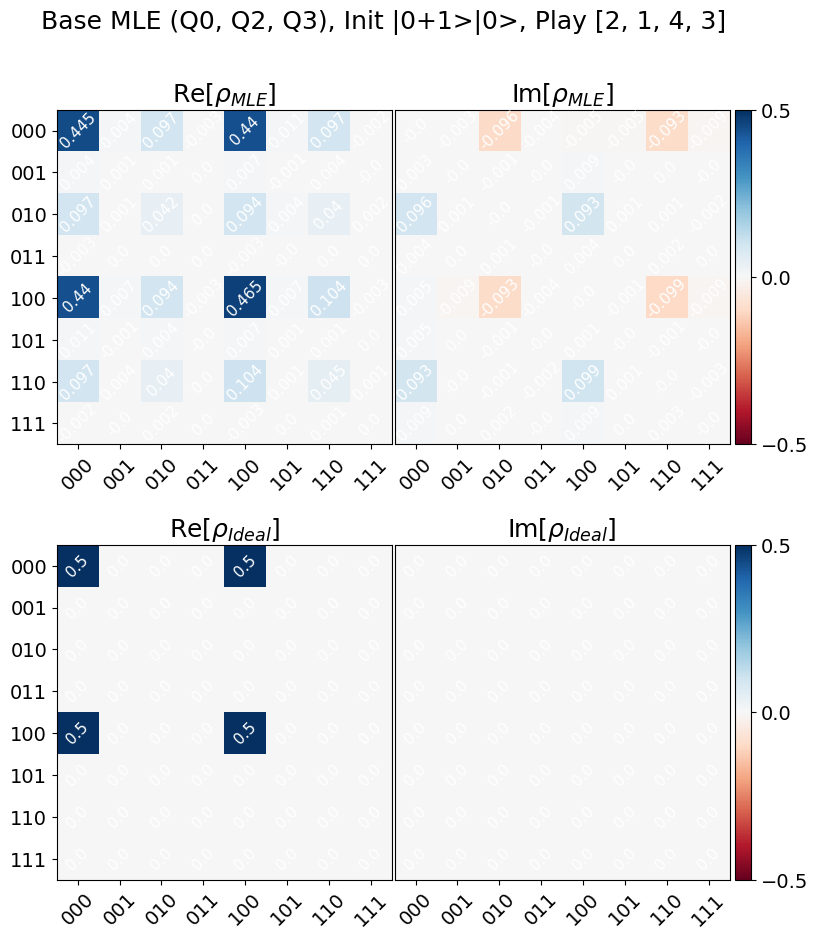

Saved data:
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_QramProtocol3QTomo.h5


In [131]:
fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
Tomo.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', cmax=0.5)

print('Saved data:')
print(*saved_files)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [124]:
evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
print('Will save evol mats to path', evol_mats_path)

qA, qB, qC = tomo_qubits
evol_mats_filename = f'_evol_mats_{qA}{qB}{qC}.npz'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path s:\Connie\experiments\qramLL_4QR2\evol_mats
Will save to filename _evol_mats_023.npz


In [110]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

qA, qB, qC = tomo_qubits
print('TOMO QUBITS', tomo_qubits)
ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_ge = np.array([f_ge[qA], f_ge[qB], f_ge[qC]])
f_ef = np.array([f_ef[qA], f_ef[qB], f_ef[qC]])
alphas = f_ef - f_ge # MHz
ZZs = np.zeros(shape=(3, 3))
ZZs = ZZs_4q[tomo_qubits][:,tomo_qubits]

# ZZs = 0*ZZs
# ZZs = 10*ZZs

print('qubit freqs', f_ge)
# print('alphas', alphas)
print('ZZs (MHz)', ZZs)
# print(pulse_dict)

print('Will save to filename', evol_mats_filename)

evol_mats = Tomo.get_evol_mats(qubits=tomo_qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, ZZs=ZZs*1e-3, pulse_dict=pulse_dict, debug=False)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

# print(evol_mats)

evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
np.savez(evol_mats_file_path, **evol_mats)
print(f'Saved evol mats to file {evol_mats_file_path}')

TOMO QUBITS [0, 2, 3]
qubit freqs [4109.19197966 4763.93206879 4380.62240711]
ZZs (MHz) [[ 0.         -0.155449   -0.48037281]
 [-0.12927573  0.         -0.4713536 ]
 [-0.4822365  -0.45079896  0.        ]]
Will save to filename _evol_mats_023.npz


  0%|          | 0/27 [00:00<?, ?it/s]

Saved evol mats to file s:\Connie\experiments\qramLL_4QR2\evol_mats\_evol_mats_023.npz


#### Reload evol mats

In [125]:
qA, qB, qC = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
# evol_mats_file_path = os.path.join(evol_mats_path, f'evol_mats_{qA}{qB}{qC}_test.npz')
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file s:\Connie\experiments\qramLL_4QR2\evol_mats\_evol_mats_023.npz


#### Actually run MLE with ZZ correction

In [183]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats) #, method='Powell')
rho_MLE_ZZ = Tomo.run_MLE_analytical(n_tomo=n_tomo, ZZ_correction=True, evol_mats=evol_mats) 
# rho_MLE_ZZ = run_MLE_analytical(n=n_tomo, ZZ_correction=True, evol_mats=evol_mats)

#, method='Powell')
# rho_MLE_ZZ = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)

 s:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 465ComplexWarning: Casting complex values to real discards the imaginary part
 s:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 470

[[ 0.445+0.j     0.003-0.j     0.096-0.097j -0.003-0.004j  0.425+0.017j
   0.012-0.004j  0.095-0.084j  0.   -0.008j]
 [ 0.003+0.j     0.002-0.j     0.   -0.001j  0.   -0.j     0.008+0.009j
  -0.001-0.001j  0.004+0.j    -0.   -0.j   ]
 [ 0.096+0.097j  0.   +0.001j  0.042-0.j     0.   -0.001j  0.083+0.097j
   0.004+0.001j  0.038+0.004j  0.002-0.002j]
 [-0.003+0.004j  0.   +0.j     0.   +0.001j  0.   -0.j    -0.004+0.004j
  -0.   -0.j     0.   +0.002j  0.   +0.j   ]
 [ 0.425-0.017j  0.008-0.009j  0.083-0.097j -0.004-0.004j  0.466+0.j
   0.004+0.001j  0.102-0.099j -0.002-0.009j]
 [ 0.012+0.004j -0.001+0.001j  0.004-0.001j -0.   +0.j     0.004-0.001j
   0.002-0.j     0.   -0.001j  0.   +0.j   ]
 [ 0.095+0.084j  0.004-0.j     0.038-0.004j  0.   -0.002j  0.102+0.099j
   0.   +0.001j  0.044-0.j     0.001-0.002j]
 [ 0.   +0.008j -0.   +0.j     0.002+0.002j  0.   -0.j    -0.002+0.009j
   0.   -0.j     0.001+0.002j  0.   -0.j   ]]
Fidelity (with ZZ correction): 0.8805406211521878
Purity (with ZZ 

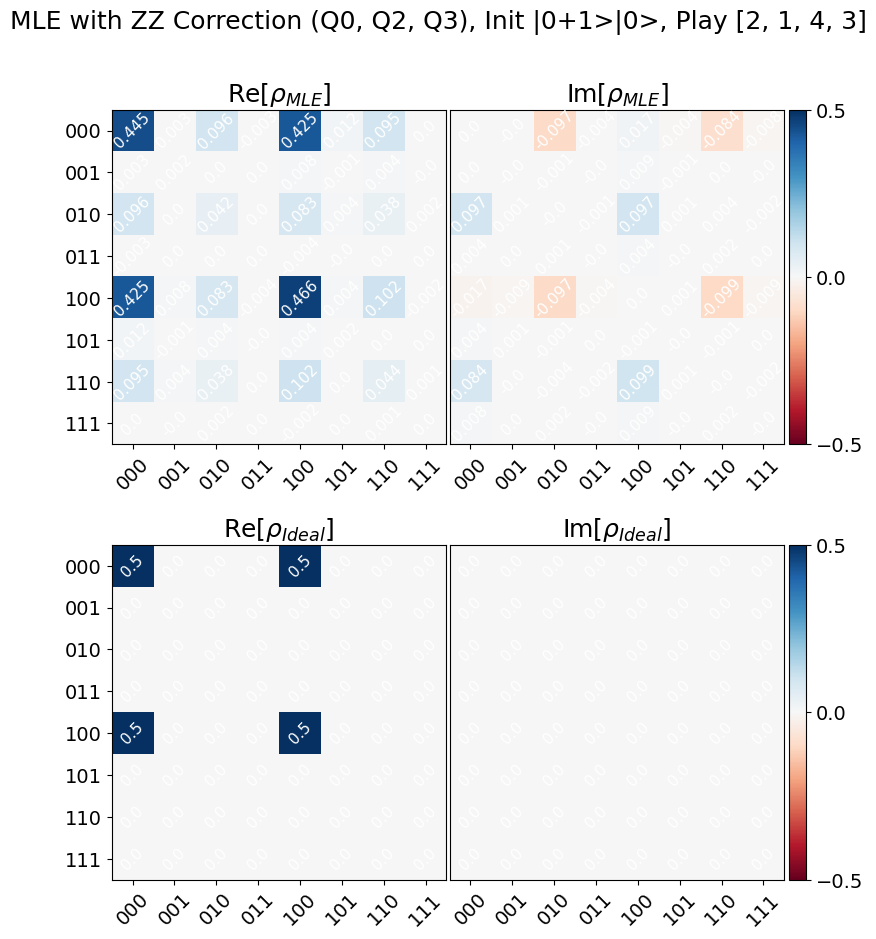

In [184]:
print(np.around(rho_MLE_ZZ, decimals=3))
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None

if savetitle is None: plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
print('init state', init_state)
Tomo.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

if save_data:
    print('Saved data:')
    print(saved_files[-1])

### Optimize over virtual Z gates on ideal rho 

Optimize over virtual Z gates on ideal rho 

In [185]:
# rho_MLE = rho_MLE_base
rho_MLE = rho_MLE_ZZ

In [207]:
phis = [None, None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
phis[2] = np.linspace(0, 360, 40)
# phis[0] = np.linspace(0, 360, 1)
# phis[1] = np.linspace(0, 360, 100)
# phis[2] = np.linspace(0, 360, 100)

rho_MLE_rot, best_phis, best_fid, fids_grid = Tomo.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('Rotation:', best_phis)

(40,)


  0%|          | 0/64000 [00:00<?, ?it/s]

Improved fidelity by (%) 0.00042980154320027
Rotation: [360.         129.23076923   0.        ]


phi Q0 360.0
fid at phi2=129.23076923076923, phi3=0.0: 0.1993187797858855
Saved S:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_QramProtocol3QTomo.svg


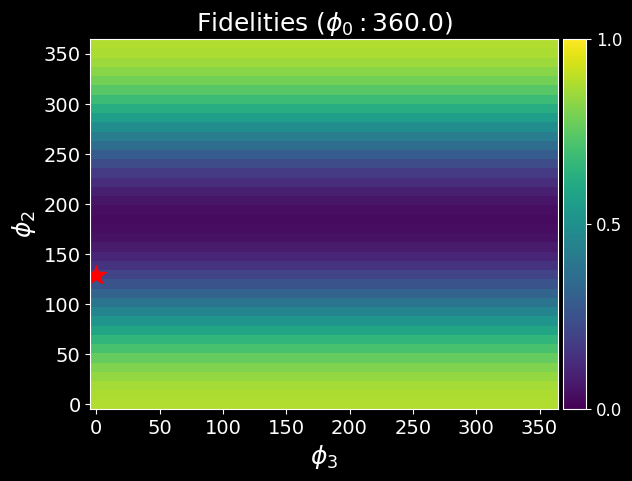

In [208]:
inner_sweep = phis[2]
outer_sweep = phis[1]
y_sweep = outer_sweep
x_sweep = inner_sweep

# vmax = np.max(fids_grid)
vmax = 1.0

# best_phis =  [350.7692307692307, 304.6153846153846, 138.46153846153845]
# best_phis =  [115, 350, 203]
# best_phis = [350.7692307692307, 18.46153846153846, 258.46153846153845]

saveplot = True
plot_filename = filename[:-3]+'.svg'
if saveplot: plt.style.use('dark_background')
best_phi_inds = [np.argmin(np.abs(phis[i]-best_phis[i])) for i in range(3)]

for i_phi0, phi0 in enumerate(phis[0]):
    if i_phi0 != best_phi_inds[0]: continue 
    print(f'phi Q0 {phi0}')
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})', fontsize=18)
    plt.xlabel(f'$\phi_{tomo_qubits[2]}$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(f'$\phi_{tomo_qubits[1]}$', fontsize=18)
    plt.yticks(fontsize=14)
    plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
    
    plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='*', markersize=15)
    print(f'fid at phi2={best_phis[1]}, phi3={best_phis[2]}:', fids_grid[i_phi0][best_phi_inds[1]][best_phi_inds[2]])
    
    # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
    # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
    # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, vmax])
    # cbar.ax.set_title(f'Fidelity')
    cbar.ax.tick_params(labelsize=12)
    plt.clim(vmin=0, vmax=vmax)
    
    if saveplot:
        plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
        print('Saved', plot_filename)
        
    plt.show()
    
# print(f'Difference between phi0[0] and phi0[1]')
# plt.figure()
# plt.title(f'Difference in fidelities ($\phi_0: $0 vs 30)')
# plt.xlabel(f'phis Q{tomo_qubits[2]}')
# plt.ylabel(f'phis Q{tomo_qubits[1]}')
# plt.pcolormesh(y_sweep, x_sweep, fids_grid[0]-fids_grid[1], cmap='viridis', shading='auto')

# # plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='o')

# # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
# # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
# # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')

# plt.colorbar()
# # plt.clim(vmin=0, vmax=1)
# plt.show()

Fidelity (after rotation): 0.8805449191676198
Purity (after rotation): 0.9272820387503777
Target purity: 1.0
Best rotation: [360.         129.23076923   0.        ]


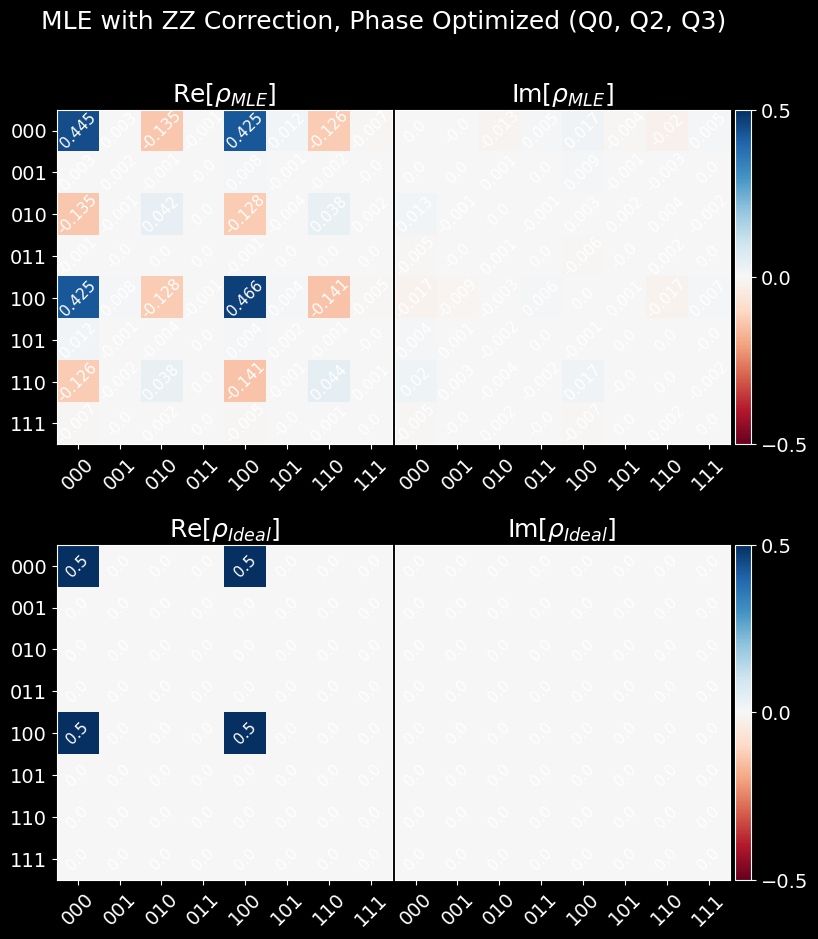

Saved data
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_QramProtocol3QTomo.h5


In [211]:
# best_phis = [0.0, 170.9090909090909, 254.54545454545453]
# best_phis = [0.0, 272.7272727272727, 167.27272727272728]
# best_phis = old_best_phis

z_phi123 = Tomo.z_gate_3q(best_phis)
rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
# savetitle=None
savetitle='_ZZcorrect_optrot.svg'
Tomo.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
print('Saved data')
print(saved_files[-1])

# Loop over 2Q sweep parameters

In [ ]:
# gain_sweep = np.linspace(2000, 25000, 11)
# opt_lens = 1e3*np.array([2.4201237152470587, 1.1987019004033739, 0.7868408797215013, 0.5851160587684981, 0.4716335769416996, 0.3999234927074055, 0.34781134410506404, 0.3089041362621608, 0.2818412962269934, 0.2636215545192442, 0.2512183319921639])
# opt_freqs = [5891.5, 5891.325, 5890.9, 5890.35, 5889.675, 5888.875, 5887.95, 5887.15, 5886.1, 5885.55, 5884.5]


gain_sweep = np.linspace(18000, 32000, 11)
opt_freqs = [5887.35, 5886.616666666667, 5885.883333333333, 5885.616666666667, 5885.116666666667, 5884.383333333333, 5884.116666666667, 5883.616666666667, 5882.883333333333, 5882.383333333333, 5882.583333333333]
opt_lens = [0.30514258121790533, 0.28952631508344284, 0.27703044436306967, 0.2646698856191053, 0.25368901625658447, 0.24735611563570364, 0.23874769989670325, 0.23044507614293083, 0.22816368954972915, 0.22170985331767395, 0.20962837376879714]

save_data = True
sweep2Q_q = 2
qubit = 2
play_pulses=[1,3]

In [ ]:
saved_files = []

init_state = '|0+1>|1>'

opt_phis = [None]

thresholds = None
angles = None
ge_avgs = None
counts_calib = None


for i_gain, gain in enumerate(gain_sweep):
    
    tomo = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    tomo.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
        reps=30000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True,
        tomo_qubits=tomo_qubits,
        init_state=init_state,
        play_pulses=play_pulses,
        thresholds=thresholds,
        angles=angles,
        ge_avgs=ge_avgs,
        counts_calib=counts_calib,
    )
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
    tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
    print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
          'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
    try:
        tomo.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(tomo.save_data())
    data = tomo.data
    if i_gain == 0:
        thresholds = data['thresholds']
        angles = data['angles']
        ge_avgs = data['ge_avgs']
        counts_calib = data['counts_calib']
    
    print()

In [ ]:
print(saved_files)

In [ ]:
print(saved_files)

### Calculate fidelities with ZZ correction and phase optimization

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

rho_id = qt.ket2dm(psis['001'] + psis['110']).unit()

for saved_file in saved_files:
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    pulse_dict = attrs['pulse_dict']
    n_tomo = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    # rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
    rho_MLE = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
    all_fids_rot.append(fid_rot)
    show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)
    


In [ ]:
# print(all_n_tomo)
# print(all_n_calib)
# print(all_fids)
print('fidelity with optimized rotation\n', all_fids_rot)
print('saved files\n', saved_files)

In [ ]:
plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

plt.xlabel(f'Length of 2Q swap in full protocol (ns)')
plt.ylabel(f'Q{sweep2Q_q} Fidelity')
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}')
plt.legend()
plt.show()